# Tranziens MHD módusok bizonytalanságbecslése FLAP segítségével
### Vavrik Márton
Motiváció:  Elmélet-kísérlet összehasonlításokhoz

L.Horváth: MHD módusok radiális változása bizonyos típusú módusoknál szignifikáns, máshol nem - a mérési bizonytalansághoz képest - fontos a bizonytalanság pontos ismerése

In [2]:
import glob
import os
from scipy import io
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import numpy as np
from scipy import signal
import copy
import time
import math

import scipy.signal
import scipy.fftpack
import scipy.integrate
import matplotlib.colors as colors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110

FLAP: Dataobject (adattárolás), transzformációk (STFT)

NTI Wavelet Tools: Gerinckövetés, hibabecslés, korrekciók

In [3]:
#useful: https://github.com/fusion-flap/flap
import sys
sys.path.append(r"E:\marci main\Fusion\flap")

import flap
print(flap.__file__)
#import flap.time_frequency_analysis
#sys.path.append(r"E:\marci main\Fusion\flap\flap")
#import time_frequency_analysis

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
import transform_error_esimation

Default location of configuration file is working directory.
INIT flap storage
E:\marci main\Fusion\flap\flap\__init__.py


## Adatok betöltése .sav fájlból, flap.DataObject létrehozása

Használt adat: AUG 32252, MHA-B31-03 mágneses diagnosztika

Disztrupció után plazmaáram csökken, ekkor tranziens MHD módus gerjesztődhet

convert_dict_to_flap: NWT része

Adattárolás: flap.DataObject (adat & koordináták)

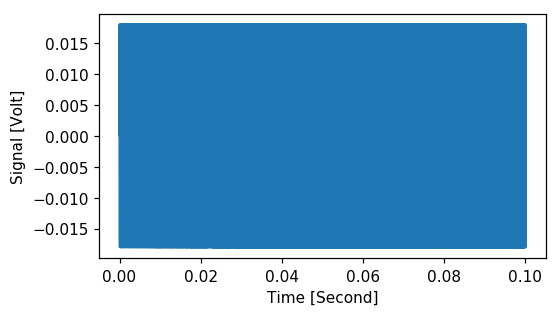


-----------------------------
TESTDATA(data_source:"TESTDATA" exp_id:"") data_title:"Test data (TEST-1-1)" shape:[100001][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:0]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E-06
Sample [a.u.](Dims:0]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E+00
Signal name [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:TEST-1-1
Column [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:1
Row [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:1
-----------------------------
TEST_STFT(data_source:"" exp_id:"") data_title:"" shape:[129,1564][no error]
  Data name:"Abs(Spectral density)", unit:""
  Coords:
Frequency [Hz](Dims:0]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  3.876E+03
Time [s](Dims:1]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  6.396E-05
Signal name [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:TEST-1-1
Column [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:1
Row [a.u.](Dims:, Shape:[]) [<R. symm.>] Val:1


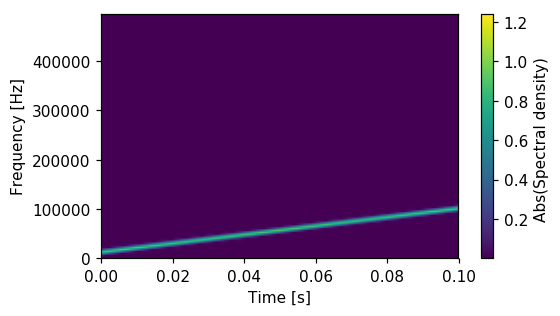

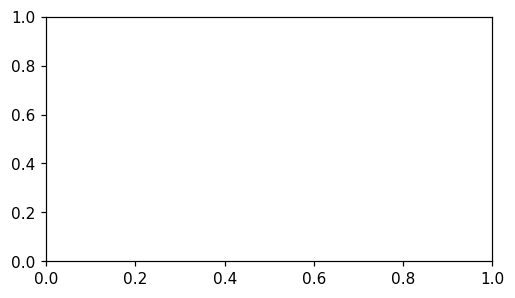

In [32]:
sys.path.append(r"E:\marci main\Fusion\flap\flap\tests")
import flap_tests

f = np.linspace(1e4,1e5,num=11)
coord = flap.Coordinate(name='Time',
                            start=0.0,
                            step=0.01,
                            mode=flap.CoordinateMode(equidistant=True),
                            dimension_list=[0]
                            )
f_obj = flap.DataObject(data_array=f,
                            coordinates=[coord],
                            data_unit=flap.Unit(name='Frequency',unit='Hz')
                            )
d=flap.get_data('TESTDATA',
                    name='TEST-1-1',
                    options={'Scaling':'Volt',
                             'Frequency':f_obj,
                             'Length':0.1,
                             'Row number':1,
                             'Column number':1
                             },
                    object_name='TESTDATA'
                    )
#d.data=100*d.data

flap.plot('TESTDATA')
s = flap.stft('TESTDATA',output_name='TEST_STFT')
s.data=100*s.data

flap.abs_value('TEST_STFT',output_name='TEST_STFT')
flap.list_data_objects()
flap.plot('TEST_STFT',axes=['Time','Frequency'],plot_type='image')

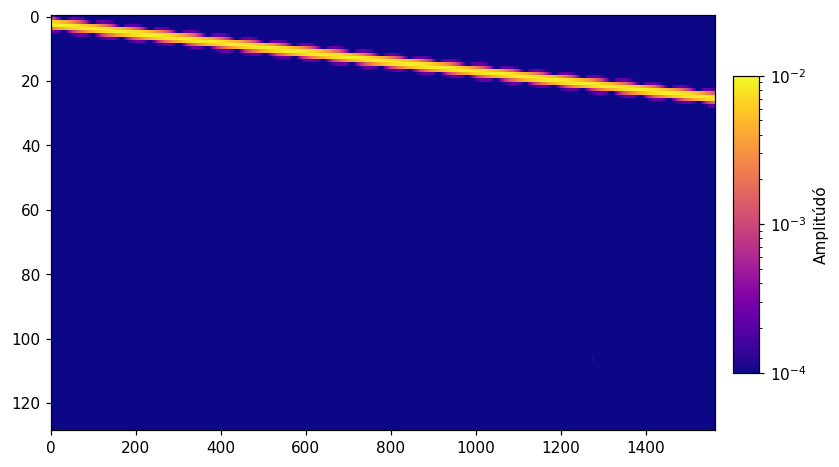

In [20]:
colornorm=colors.LogNorm(vmin=0.0001, vmax=0.01)
plt.figure(figsize=(8,5))
plt.imshow(abs(s.data),aspect='auto',norm=colornorm,cmap='plasma')
#plt.title('AUGD-32252 MHA-B31-03 STFT-je')
#plt.xlabel('Idő (s)')
#plt.ylabel('Frkvencia (Hz)')
plt.subplots_adjust(right=0.88)
#plt.ylim(0,1000000)
#plt.xlim(1.0)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.show()

In [4]:
path ='E:\\marci main\\Fusion\\inputdata\\in\\'#pc
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    loaded_sav = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')


flap_object = convert_dict_to_flap.convert_raw_sav(loaded_sav,equidistant_time=True).slice_data(
    slicing={'Time':flap.Intervals(1.002,1.009)})#,"Channels":"MHA-B31-03"})
str(flap.list_data_objects(flap_object))

Loaded: E:\marci main\Fusion\inputdata\in\AUGD_32252_Loaded-with-MTR.sav



-----------------------------
<1>(data_source:"" exp_id:"AUGD-32252") data_title:"raw data" shape:[3,14000][no error]
  Data name:"unit", unit:"a.u."
  Coords:
Time [s](Dims:1]) [<Equ.><R. symm.>] Start:  1.002E+00, Steps:  5.000E-07
Channels [a.u.](Dims:0, Shape:[3]) [<R. symm.>] Val:MHA-B31-03, MHA-B31-01, MHA-B31-02
Theta [rad](Dims:0, Shape:[3]) [<R. symm.>] Val:-4.366E-02, -4.054E-02, -3.062E-02
Phi [rad](Dims:0, Shape:[3]) [<R. symm.>] Val: 4.746E+00,  4.796E+00,  5.184E+00


'\n-----------------------------\n<1>(data_source:"" exp_id:"AUGD-32252") data_title:"raw data" shape:[3,14000][no error]\n  Data name:"unit", unit:"a.u."\n  Coords:\nTime [s](Dims:1]) [<Equ.><R. symm.>] Start:  1.002E+00, Steps:  5.000E-07\nChannels [a.u.](Dims:0, Shape:[3]) [<R. symm.>] Val:MHA-B31-03, MHA-B31-01, MHA-B31-02\nTheta [rad](Dims:0, Shape:[3]) [<R. symm.>] Val:-4.366E-02, -4.054E-02, -3.062E-02\nPhi [rad](Dims:0, Shape:[3]) [<R. symm.>] Val: 4.746E+00,  4.796E+00,  5.184E+00'

## STFT kiszámítása

flap.stft
 - scipy.signal.stft alapján (ugyanazon bemenetek)
 - Többdimenziós dataobject
 - Dataobject return
 
Most paramétek: Gauss ablak, külön állított szélesség (tartó, visszakapott adatpontok száma) és szórás (időbeli érzékenység, Gábor atom hossza)

In [6]:
samples = flap_object.data.shape[1]
n = int(12*samples**0.5)
len_fft = int(n)
fft_jump=8

flap_stft = flap_object.stft(options={'window':("gaussian",samples**0.5*0.4)})
str(flap.list_data_objects(flap_stft))


-----------------------------
<1>(data_source:"" exp_id:"AUGD-32252") data_title:"" shape:[3,129,220][no error]
  Data name:"Spectral density", unit:""
  Coords:
Frequency [Hz](Dims:1]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  7.752E+03
Time [s](Dims:2]) [<Equ.><R. symm.>] Start:  1.002E+00, Steps:  3.185E-05
Channels [a.u.](Dims:0, Shape:[3]) [<R. symm.>] Val:MHA-B31-03, MHA-B31-01, MHA-B31-02
Theta [rad](Dims:0, Shape:[3]) [<R. symm.>] Val:-4.366E-02, -4.054E-02, -3.062E-02
Phi [rad](Dims:0, Shape:[3]) [<R. symm.>] Val: 4.746E+00,  4.796E+00,  5.184E+00


'\n-----------------------------\n<1>(data_source:"" exp_id:"AUGD-32252") data_title:"" shape:[3,129,220][no error]\n  Data name:"Spectral density", unit:""\n  Coords:\nFrequency [Hz](Dims:1]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  7.752E+03\nTime [s](Dims:2]) [<Equ.><R. symm.>] Start:  1.002E+00, Steps:  3.185E-05\nChannels [a.u.](Dims:0, Shape:[3]) [<R. symm.>] Val:MHA-B31-03, MHA-B31-01, MHA-B31-02\nTheta [rad](Dims:0, Shape:[3]) [<R. symm.>] Val:-4.366E-02, -4.054E-02, -3.062E-02\nPhi [rad](Dims:0, Shape:[3]) [<R. symm.>] Val: 4.746E+00,  4.796E+00,  5.184E+00'

## STFT ábrázolása

Nyquist frekvencia: 1000004 Hz
STFT lineáris - egy tartományon karakterizáljuk a zaj eloszlását - ugyanezek a paraméterek érvényesek a móduson ülő zajra


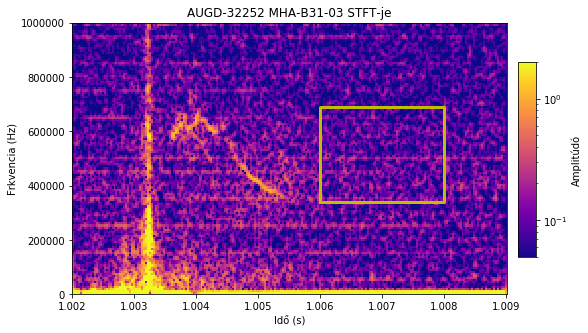

In [7]:
#segítő változók (limitek)
t_min=flap_stft.get_coordinate_object("Time").start
t_max= t_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Time").dimension_list[0]]*flap_stft.get_coordinate_object("Time").step[0]
f_min=flap_stft.get_coordinate_object("Frequency").start
f_max= f_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Frequency").dimension_list[0]]*flap_stft.get_coordinate_object("Frequency").step[0]
t_step=flap_stft.get_coordinate_object("Time").step
f_step=flap_stft.get_coordinate_object("Frequency").step
print("Nyquist frekvencia:",int(f_max),"Hz")
#print(flap_stft.data.shape[flap_stft.get_coordinate_object("Time").dimension_list[0]])

print("STFT lineáris - egy tartományon karakterizáljuk a zaj eloszlását - ugyanezek a paraméterek érvényesek a móduson ülő zajra")

colornorm=colors.LogNorm(vmin=0.05, vmax=2)
plt.figure(figsize=(8,5))
plt.imshow(abs(flap_stft.data[0]),aspect='auto',norm=colornorm,cmap='plasma',extent=(t_min,t_max,f_max,f_min))
plt.plot([1.006,1.008,1.008,1.006,1.006],[340000,340000,690000,690000,340000],'y-',linewidth=3,label="Zaj tartomány")
plt.title('AUGD-32252 MHA-B31-03 STFT-je')
plt.xlabel('Idő (s)')
plt.ylabel('Frkvencia (Hz)')
plt.subplots_adjust(right=0.88)
plt.ylim(0,1000000)
#plt.xlim(1.0)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.show()

### Zaj: Fehér, stacionárius Gauss-zaj - komplex STFT eloszlása 2D Gauss-eloszlás

<img src="Rice_graph.png" alt="drawing" width="500"/>

### Ennek abszolútértéke, mért amplitúdó: Rice-eloszlás

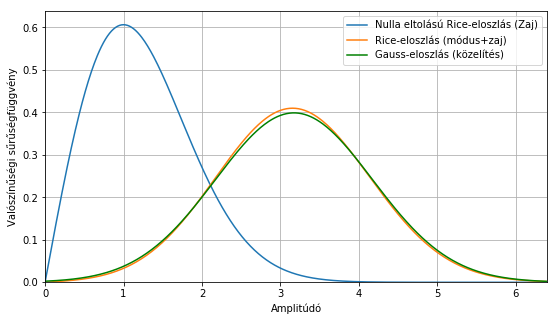

In [8]:
x2=np.linspace(start=0,num=500,stop=6.4); v2=3; s2=1

plt.figure(figsize=(9,5))
plt.plot(x2,scipy.stats.rice.pdf(x2,0,loc=0,scale=s2),'-',label="Nulla eltolású Rice-eloszlás (Zaj)") 
plt.plot(x2,scipy.stats.rice.pdf(x2,v2/s2,loc=0,scale=s2),'-',label="Rice-eloszlás (módus+zaj)") 
plt.plot(x2,scipy.stats.norm.pdf(x2,loc=transform_error_esimation.rice_amp_to_mean(v2,s2),scale=s2),'g-',label="Gauss-eloszlás (közelítés)")
plt.xlim(min(x2),max(x2))
plt.grid(True)
plt.ylim(0,0.64)
#plt.title("AUGD 32252 medián gerinc adatpontjának amplitúdóbizonytalansága")
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.legend()
plt.show()

## Zaj tartományra illeszkedő Rice eloszlás paramétereinek kiszámítása
NWT: transform_error_esimation.distribution_region_fit
 - Dimenziófüggetlen (több csatorna)
 - Bármilyen függvényt alkalmaz az utolsó 2D-re
 - Esetünkben scipy.stats.rice.fit segítségével
 - time and freq start and end (flap.dataobject.slice_data segítségével)

In [9]:
#%%script false
shape,loc,sigma=transform_error_esimation.distribution_region_fit(flap_stft.slice_data(slicing={"Channels":"MHA-B31-03"}), time_start=1.006, time_end=1.008,freq_start=340000, freq_end=690000)
print(shape,loc,sigma)
#shape,loc,sigma = 0.09345166048128055, -0.0014682223440530642, 0.08270750567449367

0.0627613829208706 0.0010445496089439195 0.08184811150378632


## Gerinc lekövetése
.get_ridge: Lokális maximumkeresés (ha az amplitúdó tú kicsi, tágabb tartományon)

Dataobject.data: amplitúdók; frekvenciák koordinátában


-----------------------------
<1>(data_source:"" exp_id:"AUGD-32252") data_title:"Ridge Amplitude" shape:[52][no error]
  Data name:"Ridge Amplitude", unit:"a.u."
  Coords:
Time [s](Dims:0]) [<Equ.><R. symm.>] Start:  1.004E+00, Steps:  3.185E-05
Channels [a.u.](Dims:, Shape:[1]) [<R. symm.>] Val:MHA-B31-03
Theta [rad](Dims:, Shape:[1]) [<R. symm.>] Val:-4.366E-02
Phi [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 4.746E+00
Ridge Frequency [Hz](Dims:0, Shape:[52]) [<R. symm.>] Val. range:  3.101E+05 -  6.512E+05


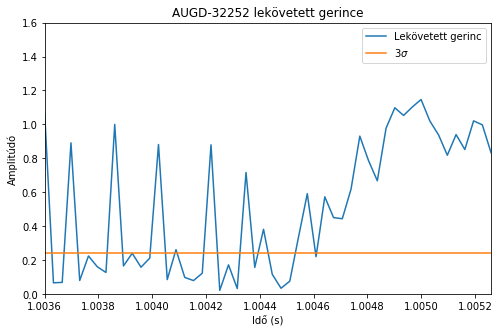

In [10]:
t1=1.0036
t2=1.00526
ridge0 = transform_error_esimation.get_ridge(flap_stft.slice_data(slicing={"Channels":"MHA-B31-03"}), search_r=50,
                                                        time_start=t1, time_end=t2, freq_start=300000, freq_end=700000)
flap.list_data_objects(ridge0)

t_ax0 = np.linspace(start=t1,stop=t2,num=len(ridge0.data))
ridge_amp0=transform_error_esimation.rice_mean_to_amp(abs(ridge0.data),sigma)

plt.figure(figsize=(8,5))
plt.plot(t_ax0,abs(ridge0.data), label="Lekövetett gerinc")
#plt.plot(t_ax2,abs(ridge2.data),alpha=0.3)
#plt.plot(t_ax,ridge_amp)
plt.plot([t1,t2],[3*sigma,3*sigma], label="$3\sigma$")
plt.legend()
plt.ylim(0,1.6)
plt.xlim(t1,t2)
plt.title('AUGD-32252 lekövetett gerince')
plt.xlabel('Idő (s)')
plt.ylabel('Amplitúdó')
plt.show()

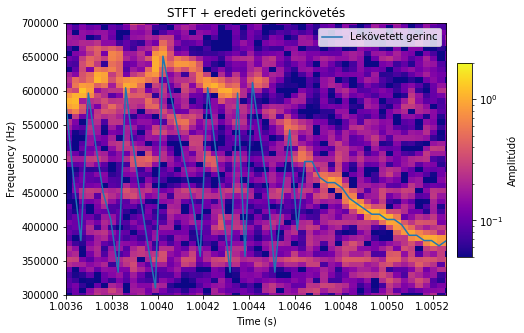

In [11]:
t_min=flap_stft.get_coordinate_object("Time").start
t_max= t_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Time").dimension_list[0]]*flap_stft.get_coordinate_object("Time").step[0]
f_min=flap_stft.get_coordinate_object("Frequency").start
f_max= f_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Frequency").dimension_list[0]]*flap_stft.get_coordinate_object("Frequency").step[0]
t_step=flap_stft.get_coordinate_object("Time").step
f_step=flap_stft.get_coordinate_object("Frequency").step

ridgef=ridge0.get_coordinate_object("Ridge Frequency").values
colornorm=colors.LogNorm(vmin=0.05, vmax=2)
plt.figure(figsize=(7,5))
plt.imshow(abs(flap_stft.data[0]),interpolation="none",aspect='auto',norm=colornorm,cmap='plasma',extent=(t_min,t_max,f_max,f_min))
plt.plot(np.linspace(start=t1,stop=t2,num=len(ridgef)),ridgef,label="Lekövetett gerinc")
plt.legend()
plt.title('STFT + eredeti gerinckövetés')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplots_adjust(right=0.88)
plt.ylim(300000,700000)
plt.xlim(t1,t2)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.show()

Gerinckövető nem érzékeli a globális struktúrát

## Felhasználó által beadott gerinc finomítása
P.Heinrich által Dijkstra algoritmusával elvégzett keresés

In [12]:
heinrich_f = np.array([590000, 600000, 630000, 610000, 630000, 640000, 630000, 600000, 570000, 570000, 550000, 490000, 470000, 430000, 420000, 390000, 380000, 380000])

#tengelyek és DataObject létrehozása
heinrich_f_ax = flap.Coordinate(name="Ridge Frequency",
                              unit="Hz",
                              mode=flap.CoordinateMode(equidistant=False),
                              values=heinrich_f,
                              dimension_list=[0],
                              shape=len(heinrich_f)
                              )
time_ax = flap.Coordinate(name="Time",
                                      unit="s",
                                      mode=flap.CoordinateMode(equidistant=True),
                                      start=t1,
                                      step=(t2-t1) / len(heinrich_f),
                                      dimension_list=[0],
                                      #shape=len(heinrich_f)
                                      )
heinrich_obj=flap.DataObject(data_array=None, #nem kell adat sem
                                data_unit=flap.Unit(name='Ridge Amplitude', unit='a.u.'),
                                exp_id=flap_stft.exp_id,
                                data_title="Ridge Amplitude",
                                coordinates=[heinrich_f_ax,time_ax],
                                data_shape=ridge0.shape)
#print(np.diff(np.unique(heinrich_f)).min()) - frequency sample size

ridge= transform_error_esimation.refine_ridge(flap_stft.slice_data(slicing={"Channels":"MHA-B31-03"}),heinrich_obj,search_r=12000)
flap.list_data_objects(ridge0)
flap.list_data_objects(ridge)

t_ax = np.linspace(start=t1,stop=t2,num=len(ridge.data))
ridge_amp=transform_error_esimation.rice_mean_to_amp(abs(ridge.data),sigma)

1
(52,)

-----------------------------
<1>(data_source:"" exp_id:"AUGD-32252") data_title:"Ridge Amplitude" shape:[52][no error]
  Data name:"Ridge Amplitude", unit:"a.u."
  Coords:
Time [s](Dims:0]) [<Equ.><R. symm.>] Start:  1.004E+00, Steps:  3.185E-05
Channels [a.u.](Dims:, Shape:[1]) [<R. symm.>] Val:MHA-B31-03
Theta [rad](Dims:, Shape:[1]) [<R. symm.>] Val:-4.366E-02
Phi [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 4.746E+00
Ridge Frequency [Hz](Dims:0, Shape:[52]) [<R. symm.>] Val. range:  3.101E+05 -  6.512E+05

-----------------------------
<1>(data_source:"" exp_id:"AUGD-32252") data_title:"Ridge Amplitude" shape:[52][no error]
  Data name:"Ridge Amplitude", unit:"a.u."
  Coords:
Ridge Frequency [Hz](Dims:0, Shape:[52]) [<R. symm.>] Val. range:  3.721E+05 -  6.357E+05
Time [s](Dims:1]) [<Equ.><R. symm.>] Start:  1.004E+00, Steps:  3.185E-05


## Javított kerinckövetés frekvenciája

1000004.9999999991
220


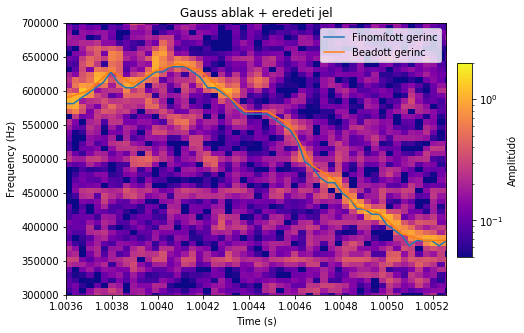

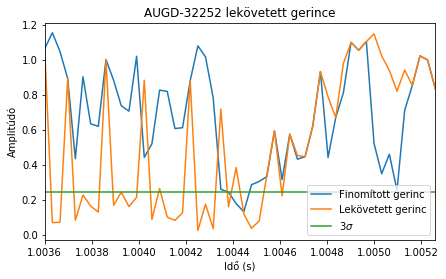

In [13]:
t_min=flap_stft.get_coordinate_object("Time").start
t_max= t_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Time").dimension_list[0]]*flap_stft.get_coordinate_object("Time").step[0]
f_min=flap_stft.get_coordinate_object("Frequency").start
f_max= f_min + flap_stft.data.shape[flap_stft.get_coordinate_object("Frequency").dimension_list[0]]*flap_stft.get_coordinate_object("Frequency").step[0]
t_step=flap_stft.get_coordinate_object("Time").step
f_step=flap_stft.get_coordinate_object("Frequency").step
print(f_max)
print(flap_stft.data.shape[flap_stft.get_coordinate_object("Time").dimension_list[0]])
#limits=(min_t*s_rate/d_win,max_t*s_rate/d_win,max_t*s_rate,min_t*s_rate)

ridgef=ridge0.get_coordinate_object("Ridge Frequency").values
ridgef2=ridge.get_coordinate_object("Ridge Frequency").values
ridgef_old=heinrich_obj.get_coordinate_object("Ridge Frequency").values
colornorm=colors.LogNorm(vmin=0.05, vmax=2)
plt.figure(figsize=(7,5))
plt.imshow(abs(flap_stft.data[0]),aspect='auto',norm=colornorm,cmap='plasma',extent=(t_min,t_max,f_max,f_min))#, cmap='bwr',
#plt.plot(np.linspace(start=t1,stop=t2,num=len(ridgef)),ridgef,label="Lekövetett gerinc")
plt.plot(np.linspace(start=t1,stop=t2,num=len(ridgef2)),ridgef2,label="Finomított gerinc" )
plt.plot(np.linspace(start=t1,stop=t2,num=len(ridgef_old)),ridgef_old, label="Beadott gerinc")
plt.legend()
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplots_adjust(right=0.88)
plt.ylim(300000,700000)
plt.xlim(t1,t2)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.show()

plt.figure(figsize=(7,4))
plt.plot(t_ax,abs(ridge.data),label="Finomított gerinc")
#plt.plot(t_ax2,ridge_amp2)
plt.plot(t_ax0,abs(ridge0.data),label="Lekövetett gerinc")
plt.plot([t1,t2],[3*sigma,3*sigma],label="3$\sigma$")
plt.title('AUGD-32252 lekövetett gerince')
plt.xlabel('Idő (s)')
plt.ylabel('Amplitúdó')
plt.xlim(t1,t2)
#plt.plot(t_ax,ridge_amp)
plt.legend()
plt.show()

Rice eloszlás: asszimetrikus - várható érték $\neq$ $\mu$ eltolás

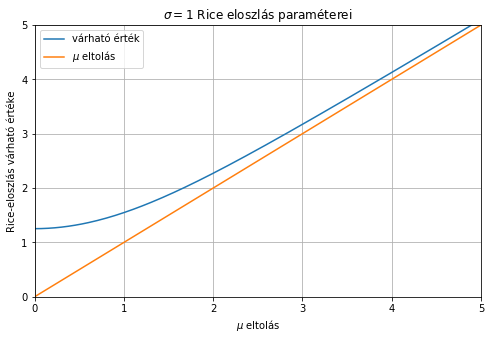

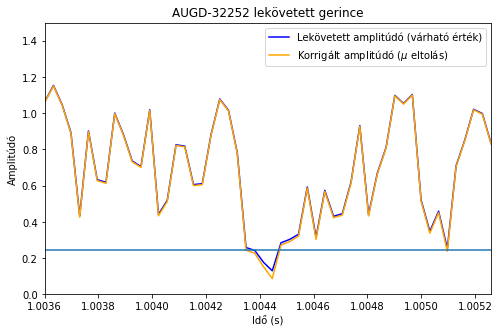

In [14]:
amps = np.linspace(start=0,stop=5,num=200)

plt.figure(figsize=(8,5))
plt.plot(amps,transform_error_esimation.rice_amp_to_mean(amps,sigma=1),label="várható érték")
plt.plot(amps,amps,label="$\mu$ eltolás")
plt.title('$\sigma=1$ Rice eloszlás paraméterei')
plt.xlabel("$\mu$ eltolás")
plt.ylabel("Rice-eloszlás várható értéke")
plt.ylim(0,5)
plt.xlim(0,5)
plt.legend()
plt.grid(True)
#plt.savefig("amp-mean", dpi =200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(t_ax,abs(ridge.data),"blue",label="Lekövetett amplitúdó (várható érték)")
plt.plot(t_ax,ridge_amp,"orange",label="Korrigált amplitúdó ($\mu$ eltolás)")
plt.plot([t1,t2],[3*sigma,3*sigma])
plt.ylim(0,1.5)
plt.xlim(t1,t2)
plt.title('AUGD-32252 lekövetett gerince')
plt.xlabel('Idő (s)')
plt.ylabel('Amplitúdó')
plt.legend()
plt.show()

NWT: rice_amp_to_mean és rice_mean_to_amp konverziók (első zárt formula, de nem invertálható, így második interpolálva)

Az amplitúdó hibáját is transzformálni kell - kis amplitúdónál látványosan nő a hiba (asszimmetrikusan) 

<img src="amp-mean.png" alt="drawing" width="600"/>

## Rice eloszlás sűrűségfüggvénye minimum amplitúdónál

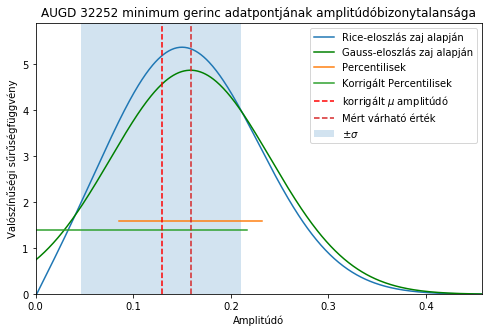

In [15]:
v2=np.min(np.abs(ridge.data))#np.mean(np.abs(ridge_amp))
v2_e=transform_error_esimation.rice_amp_to_mean(v2,sigma)

x2=np.linspace(start=0,num=500,stop=v2+4*sigma)#
distmax=np.max(scipy.stats.rice.pdf(x2,v2/sigma,loc,sigma))
err1,err2=transform_error_esimation.rice_get_error_bars(v2/sigma,loc,sigma)

plt.figure(figsize=(8,5))
#plt.plot(dist_x,n,'.-')
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(x2,scipy.stats.rice.pdf(x2,v2/sigma,loc=loc,scale=sigma),'-',label="Rice-eloszlás zaj alapján") 
plt.plot(x2,scipy.stats.norm.pdf(x2,loc=v2_e,scale=sigma),'g-',label="Gauss-eloszlás zaj alapján")
plt.plot([err2,err1],[1.6,1.6],label="Percentilisek")
plt.plot([transform_error_esimation.rice_mean_to_amp(err2,sigma),
          transform_error_esimation.rice_mean_to_amp(err1,sigma)],
         [1.4,1.4],label="Korrigált Percentilisek")
#plt.plot([v2-loc,v2-loc+sigma*1.17741],[distmax/2,distmax/2],label="FWHM/2 = $1.177*\sigma$")#
#plt.plot([v2-loc,v2-loc+sigma],[distmax,distmax],label="$\sigma$")#
#plt.plot([v2-loc-sigma,v2-loc+sigma],[distmax/2,distmax/2],label="$\pm\sigma$")#
plt.fill([v2-loc-sigma,v2-loc-sigma,v2-loc+sigma,v2-loc+sigma],[0,10,10,0],alpha=0.2,label="$\pm\sigma$")
plt.plot([v2,v2],[0,20],"--",color="red",label="korrigált $\mu$ amplitúdó")
plt.plot([v2_e,v2_e],[0,20],"--",label="Mért várható érték")
#plt.xlim(0,v2+3*sigma)
plt.xlim(min(x2),max(x2))
plt.ylim(0,distmax*1.1)
plt.title("AUGD 32252 minimum gerinc adatpontjának amplitúdóbizonytalansága")
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.legend()
plt.show()

Kis amplitúdó: Gauss-közelítés nem alkalmazható, korrekciók igen jelentősek

Asszimmetrikus hibasávok (nagy amplitúdónál $\sigma$-nak megfelelő kvantilisek) - NWT: transform_error_esimation.rice_get_error_bars

Amiket ugyanúgy transzformáljuk: transform_error_esimation.rice_mean_to_amp

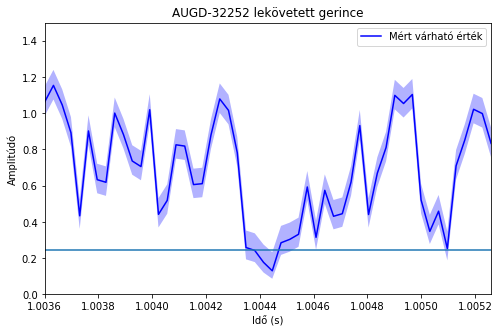

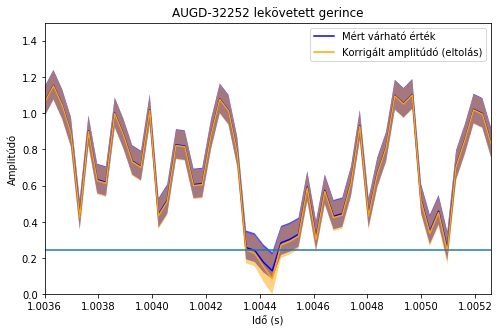

In [16]:
mean_err1=np.empty(len(ridge_amp))
mean_err2=np.empty(len(ridge_amp))
amp_err1=np.empty(len(ridge_amp))
amp_err2=np.empty(len(ridge_amp))
for i in range(len(ridge_amp)):
    mean_err2[i], mean_err1[i] = transform_error_esimation.rice_get_error_bars(abs(ridge.data[i])/sigma,loc,sigma)
    #print(mean_err2[i])
    amp_err1[i] = transform_error_esimation.rice_mean_to_amp(mean_err1[i],sigma)
    amp_err2[i] = transform_error_esimation.rice_mean_to_amp(mean_err2[i],sigma)
    

plt.figure(figsize=(8,5))
plt.fill(np.concatenate((t_ax, t_ax[::-1])),np.concatenate((mean_err1, (mean_err2)[::-1])),"blue",alpha=0.3)
plt.plot(t_ax,abs(ridge.data),"blue", label="Mért várható érték")
plt.plot([t1,t2],[3*sigma,3*sigma])
plt.ylim(0,1.5)
plt.xlim(t1,t2)
plt.title('AUGD-32252 lekövetett gerince')
plt.xlabel('Idő (s)')
plt.ylabel('Amplitúdó')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.fill(np.concatenate((t_ax, t_ax[::-1])),np.concatenate((mean_err1, (mean_err2)[::-1])),"blue",alpha=0.7)
plt.plot(t_ax,abs(ridge.data),"blue", label="Mért várható érték")
plt.fill(np.concatenate((t_ax, t_ax[::-1])),np.concatenate((amp_err1, (amp_err2)[::-1])),"orange",alpha=0.5)
plt.plot(t_ax,ridge_amp,"orange", label="Korrigált amplitúdó (eltolás)")
plt.plot([t1,t2],[3*sigma,3*sigma])
plt.ylim(0,1.5)
plt.xlim(t1,t2)
plt.title('AUGD-32252 lekövetett gerince')
plt.xlabel('Idő (s)')
plt.ylabel('Amplitúdó')
plt.legend()
plt.show()

## Összefoglalás

 - Feldolgozás NWT-ben, FLAP adatstruktúrákkal (beolvasás és mentés)
 - STFT algoritmus FLAP-ben
 - Feldolgozás  NWT-ben:
  - Gerinckövetés és finomítás
  - Zaj tartomány eloszlásának illesztése
  - Paraméterekből gerincamplitúdó bizonytalansága
  - Várható érték korrekció
 
Terv: Módus jelenlétének konfidencia-vizsgálata, fázis bizonytalansága (eloszlást ismerjük)